# From DNA to Model Input:  Intro

In this notebook, we will walk through the process of taking raw DNA sequences and preparing them for input into a sequence-to-function (S2F) model.  

- Inspect DNA sequences and extract simple features
- One-hot encode sequences into numerical arrays
- Split a dataset into training and test sets
- Train a simple classifier and visualize outputs


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


## Step 1: Toy DNA Dataset

Let's start with a few short DNA sequences. In real applications, these would come from sequencing experiments (e.g., ATAC-seq, RNA-seq).


In [17]:
sequences = [
    "ATGCGTACGTAGCTAG",
    "GGCATTATGTATATAT",
    "CGTATGCATGCGTAGC",
    "ATGATTTGTGTCATGC",
    "TTGCGATGCTAGCATG",
    "ATGCATGCATGCATGC",
    "GGGCGCGTATATATAT",
    "ATGCGTACGTAGATAG",
    "ATGCATATTTGCATGC",
    "GGGCGCGTAGGCTTAT",
    "ATGATTTGTGTCATGC",
    "CGTATGCATGCGTCCC",
    "GGGATTATGTATATAT",
    "ATGATTTGTGTCATGC",
    "CGTATGCATGGGTGCC",
]

# pretend labels (e.g., accessible = 1, not accessible = 0)
labels = [1,0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1 ]


In [2]:
def generate_sequence(class_label, length=30):
    """
    Generate DNA sequences with same composition but different motif arrangement.
    Class 1: 'ATG' followed by 'C'
    Class 0: 'ATG' followed by 'T'
    """
    # Build balanced pool (equal A,C,G,T, adjusted to length)
    base_pool = (["A","C","G","T"] * (length//4)) + random.choices("ACGT", k=length % 4)
    random.shuffle(base_pool)  # shuffle in place

    pos = random.randint(0, length-4)
    base_pool[pos:pos+3] = list("ATG")
    if class_label == 1:
        base_pool[pos+3] = "C"
    else:
        base_pool[pos+3] = "T"

    return "".join(base_pool)


In [4]:
n_samples = 500
sequences = [generate_sequence(i % 2) for i in range(n_samples)]
labels = [i % 2 for i in range(n_samples)]

print("Example Class 1:", sequences[0])
print("Example Class 0:", sequences[1])


Example Class 1: TTAGGAATTCGAATGTTGACGCACACCTTG
Example Class 0: GACACCGTCTACGATGCTTTCCGATAATGC


## Step 2: Sequence Inspection

We can calculate nucleotide frequencies, GC content, and visualize distributions.


In [5]:
def nucleotide_counts(seq):
    return {nt: seq.count(nt) for nt in "ACGT"}

# apply nucleotide_counts to a single sequence
one_seq_counts = nucleotide_counts('ACCCGCTC')
print(one_seq_counts)

# apply nucleotide_counts to our list of sequences
seq_list_counts = [nucleotide_counts(seq) for seq in sequences]
print(seq_list_counts)


{'A': 1, 'C': 5, 'G': 1, 'T': 1}
[{'A': 8, 'C': 6, 'G': 7, 'T': 9}, {'A': 7, 'C': 9, 'G': 6, 'T': 8}, {'A': 9, 'C': 6, 'G': 7, 'T': 8}, {'A': 8, 'C': 6, 'G': 8, 'T': 8}, {'A': 8, 'C': 6, 'G': 8, 'T': 8}, {'A': 8, 'C': 8, 'G': 7, 'T': 7}, {'A': 9, 'C': 8, 'G': 6, 'T': 7}, {'A': 7, 'C': 7, 'G': 7, 'T': 9}, {'A': 8, 'C': 6, 'G': 7, 'T': 9}, {'A': 8, 'C': 7, 'G': 7, 'T': 8}, {'A': 9, 'C': 5, 'G': 8, 'T': 8}, {'A': 9, 'C': 9, 'G': 6, 'T': 6}, {'A': 5, 'C': 8, 'G': 8, 'T': 9}, {'A': 8, 'C': 9, 'G': 8, 'T': 5}, {'A': 7, 'C': 6, 'G': 7, 'T': 10}, {'A': 8, 'C': 8, 'G': 6, 'T': 8}, {'A': 7, 'C': 7, 'G': 7, 'T': 9}, {'A': 7, 'C': 8, 'G': 8, 'T': 7}, {'A': 7, 'C': 8, 'G': 7, 'T': 8}, {'A': 8, 'C': 9, 'G': 7, 'T': 6}, {'A': 8, 'C': 7, 'G': 8, 'T': 7}, {'A': 8, 'C': 8, 'G': 5, 'T': 9}, {'A': 7, 'C': 7, 'G': 6, 'T': 10}, {'A': 9, 'C': 7, 'G': 6, 'T': 8}, {'A': 6, 'C': 5, 'G': 8, 'T': 11}, {'A': 7, 'C': 7, 'G': 6, 'T': 10}, {'A': 9, 'C': 7, 'G': 6, 'T': 8}, {'A': 6, 'C': 9, 'G': 8, 'T': 7}, {'A': 8, '

## Step 3: One-Hot Encoding DNA

Machine learning models require numerical input. A common way to represent DNA is **one-hot encoding**:
- A = [1,0,0,0]
- C = [0,1,0,0]
- G = [0,0,1,0]
- T = [0,0,0,1]


In [6]:
def one_hot_encode(sequence):
    seq_array = np.array(list(sequence))[:, None]
    bases = np.array(list('ACGT'))
    one_hot = (seq_array == bases).astype(np.float32)
    return one_hot

first_sequence_OHE = one_hot_encode(sequences[0]) # one hot encoding for the first sequence in the list
print(first_sequence_OHE.shape) # shape of the one-hot encoded array length x 4 (one channel per nucleotide)
print(first_sequence_OHE)


(30, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


## Step 4 : Dataset Shapes

There are two ways to structure one-hot encoded sequences:

1. **Flattened representation** (each sequence is turned into a 1D vector)  
   - Shape: `(n_samples, seq_len*4)`  
   - Works for simple linear ML models (like logistic regression).  

2. **Tensor representation** (keep sequence positions and nucleotide channels separate)  
   - Shape: `(n_samples, seq_len, 4)`  
   - Natural input for CNNs and deep learning models.  

Let's look at both.


#### Scenario 1: Flattened for simple models
Here we have a nucleotide representation every 4 positions following the format ACGT-ACGT-ACGT..
* So for the sequence AGT the flattened representation will be 
    - [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] 

In [9]:
# Flattened: shape (n_samples, seq_len*4)
X_flat = np.array([one_hot_encode(seq).flatten() for seq in sequences])
y = np.array(labels)

print("Flattened dataset shape:", X_flat.shape)
print("Example flattened vector:", X_flat[0])  

Flattened dataset shape: (500, 120)
Example flattened vector: [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]


#### Scenario 2: Tensor (for Deep Learning models)
Now the AGT will be represented as a 2D matrix instead of a flattened list
$$
\begin{bmatrix}
1 & 0 & 0 & 0 & (A)\\\\
0 & 0 & 1 & 0 & (G)\\\\
0 & 0 & 0 & 1 & (T)
\end{bmatrix}
$$

This format keeps the positional structure of the sequence and is the natural input for CNNs and transformers.


Tensor dataset shape: (500, 30, 4)


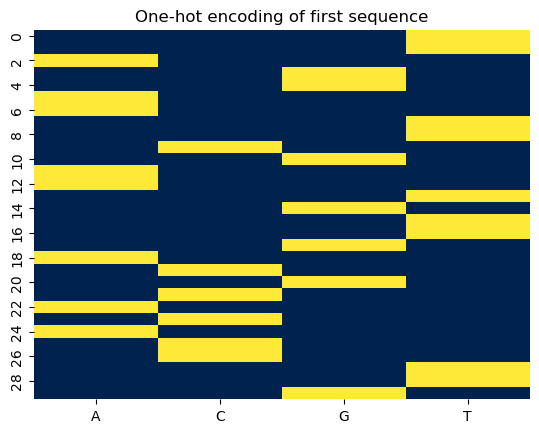

In [10]:
# Tensor: shape (n_samples, seq_len, 4)
X_tensor = np.array([one_hot_encode(seq) for seq in sequences])
print("Tensor dataset shape:", X_tensor.shape)
# visualize the one-hot encoding
# for each position in the sequence, there is a 1 (yellow) in the channel corresponding to the nucleotide at that position
sns.heatmap(first_sequence_OHE, cmap="cividis", cbar= False,xticklabels=list("ACGT"))
plt.title("One-hot encoding of first sequence")
plt.show()


## Step 5: Train/Test Split
We always split into training and test sets to evaluate model performance fairly.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 350 Test size: 150


## Step 6: Simple Classifier
We'll use a logistic regression model (very basic). Real S2F models often use CNNs or transformers, but this illustrates the principle.


Test Accuracy: 0.7133333333333334


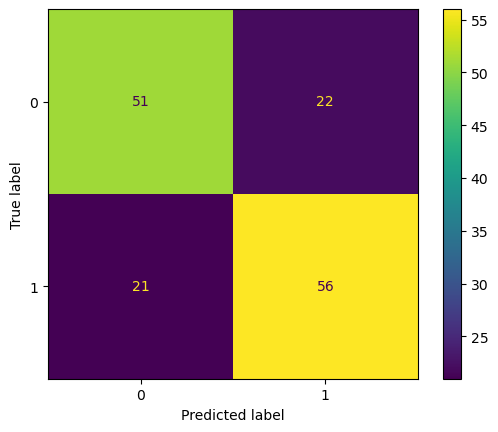

In [12]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


## Step 7: Why Linear Models Are Not Enough

Our logistic regression reached an accuracy of 0.5 on this toy dataset.  
That’s not bad for a start but would not be the case in a real complex sequence — but there are important **limitations**:

- **Linear decision boundaries:** Logistic regression (and other linear models) can only separate classes if they are linearly separable.  
- **No positional awareness:** Flattening the sequence destroys positional structure. The model cannot detect motifs like "ATG" occurring in a specific region.  
- **No higher-order dependencies:** Linear models cannot capture interactions between nucleotides or motifs (e.g., enhancers, binding sites).  

In biology, regulatory function often depends on **non-linear motif combinations** and **context**.  
That’s why we use **non-linear models** such as convolutional neural networks (CNNs) or transformers.

## Step 8: Moving to Tensor Representations

To model biological sequences more realistically, we keep the data in its natural format:

- Shape: `(n_samples, seq_len, 4)`  
- Each row corresponds to a nucleotide position.  
- Each column corresponds to one channel (A, C, G, T).  

This allows the model to **slide filters across the sequence** (like scanning windows) and detect motifs.  

Let’s prepare the tensor dataset for deep learning.


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convert dataset into tensor format
X_tensor = torch.tensor([one_hot_encode(seq) for seq in sequences], dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)

print("Tensor dataset shape:", X_tensor.shape)  # (samples, seq_len, 4)


Tensor dataset shape: torch.Size([500, 30, 4])


/tmp/ipykernel_3350732/159780335.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_tensor = torch.tensor([one_hot_encode(seq) for seq in sequences], dtype=torch.float32)


## Step 9: A Simple 1D Convolutional Model

We will define a very small CNN that scans the sequence and tries to classify it.  
This is just to illustrate the concept. In practice, S2F models are much deeper.


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(8 * X_tensor.shape[1], 2)  # 2 classes (labels 0/1)

    def forward(self, x):
        # input shape: (batch, seq_len, 4) → we transpose to (batch, channels, seq_len)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=240, out_features=2, bias=True)
)


In [23]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays into torch tensors
X_torch = torch.tensor(X_tensor, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.long)

# Random 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X_torch, y_torch, test_size=0.3, random_state=42, shuffle=True
)

# Wrap in TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(20):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

print("Finished training")


/tmp/ipykernel_3350732/1043679892.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_torch = torch.tensor(X_tensor, dtype=torch.float32)


Finished training


## Step 11: Evaluation

Let's test the CNN on the held-out sequences.


In [24]:
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        pred_labels = preds.argmax(dim=1)
        correct += (pred_labels == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {correct/total:.2f}")


Test Accuracy: 0.78


## Why Does a 1D CNN Work Better?

In our dataset, both classes have the **same nucleotide composition**.  
The only difference is in the **motif arrangement**:
- Class 1 → `"ATG"` followed by `"C"`
- Class 0 → `"ATG"` followed by `"T"`

A **linear model** (like logistic regression):
- Flattens the sequence into a long vector.
- Only "sees" the total counts of nucleotides.
- Cannot capture **order** or **local dependencies**.

A **1D Convolutional Neural Network (CNN)**:
- Treats the DNA sequence as a tensor: `(sequence_length, 4 channels for ACGT)`.
- Uses **filters (kernels)** that slide across the sequence.
- Each filter learns to detect short **motifs** (e.g., "ATGC" vs "ATGT").
- Since the filter slides across the sequence, it can detect motifs **anywhere**, not just in one fixed position.

This is why CNNs are a much better fit for biological sequence data.


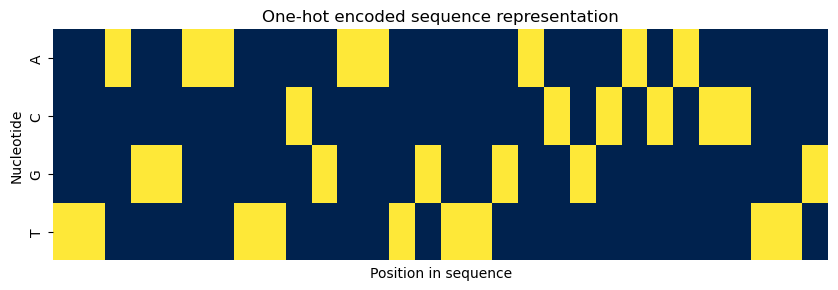

In [25]:
# Take one example sequence
example_seq = sequences[0]
example_encoded = one_hot_encode(example_seq)

plt.figure(figsize=(10, 3))
sns.heatmap(example_encoded.T, cmap="cividis", cbar=False,
            xticklabels=False, yticklabels=list("ACGT"))
plt.title("One-hot encoded sequence representation")
plt.ylabel("Nucleotide")
plt.xlabel("Position in sequence")
plt.show()
